In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [10]:
def extract_cols(df):
    df['seed'] = df['data'].apply(lambda x: int(x.split('/')[1].split('.')[0].split('_')[-1]))
    return df

def best_all(df, params):
    df['hyper_id'] = df.groupby(params, dropna=False).ngroup()
    gr = df.groupby(['hyper_id'])['SHD_pattern'].agg(['mean', 'sem']).reset_index()

    hyper_id_sel = gr.loc[gr['mean'].idxmin(), 'hyper_id']
    df['hyper_id_sel'] = hyper_id_sel

    df2 = df.loc[df['hyper_id'] == df['hyper_id_sel']]
    df3 = df2['SHD_pattern'].agg(['mean', 'sem'])

    return df3

def best_h(df):
    return extract_cols(df).groupby(['id', 'seed'], as_index=False).apply(lambda x: x.loc[x['SHD_pattern'].idxmin()])

def worst_h(df):
    return extract_cols(df).groupby(['id', 'seed'], as_index=False).apply(lambda x: x.loc[x['SHD_pattern'].idxmax()])

In [29]:
with open('../config/algos_repo.json', 'r') as f:
    config = json.load(f)

algs = []

obj = config['resources']['structure_learning_algorithms']
for alg in obj:
    try:
        df = pd.read_csv(f'./results/syntren/{alg}.csv')
    except:
        continue

    print(alg)
    params = list(obj[alg][0].keys())

    df_def = best_all(df, params)
    df_def['id'] = df['id'].unique()[0]
    algs.append(df_def)
    
df_defs = pd.DataFrame(algs)

bench_all = pd.read_csv('./results/syntren/joint_benchmarks.csv', index_col=0)
df_best = best_h(bench_all).groupby(['id'], as_index=False)['SHD_pattern'].agg(['mean', 'sem']).reset_index()
df_worst = worst_h(bench_all).groupby(['id'], as_index=False)['SHD_pattern'].agg(['mean', 'sem']).reset_index()

pcalg_pc
tetrad_fges
tetrad_fci
gcastle_ica_lingam
gcastle_anm
cdt_cam
gcastle_notears
gcastle_notears_nonlinear


## Plots

In [21]:
df_best_plt = df_best.rename(columns={'mean': 'SHD'}).drop(columns=['sem'])
df_best_plt['quality'] = 'best'

df_worst_plt = df_worst.rename(columns={'mean': 'SHD'}).drop(columns=['sem'])
df_worst_plt['quality'] = 'worst'

df_defs_plt = df_defs.rename(columns={'mean': 'SHD'}).drop(columns=['sem'])
df_defs_plt['quality'] = 'default'

df_final = pd.concat([df_best_plt, df_defs_plt, df_worst_plt], axis=0)

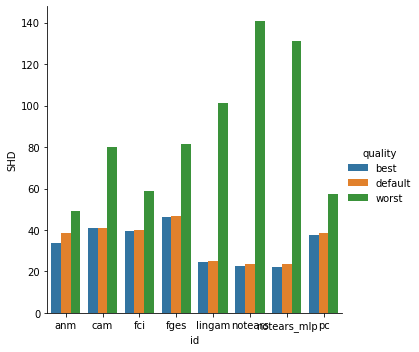

In [22]:
sns.catplot(data=df_final, x='id', y='SHD', hue='quality', kind='bar', ci=None)

## Tables

In [31]:
df_best['best'] = df_best.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_best.drop(columns=['sem'], inplace=True)

df_defs['default'] = df_defs.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_defs.drop(columns=['sem'], inplace=True)

df_worst['worst'] = df_worst.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_worst.drop(columns=['sem'], inplace=True)

merge_key = ['id']
df_final = df_best.merge(df_defs, on=merge_key).merge(df_worst, on=merge_key)

df_final['id'] = df_final.apply(lambda x: x['id'].upper(), axis=1)
df_final.set_index('id', inplace=True)

In [32]:
df_final[['best', 'default', 'worst']]

,best,default,worst
id,,,
ANM,33.5 (3.79),38.3 (4.09),49.2 (4.64)
CAM,40.9 (2.49),41.0 (2.47),80.2 (2.11)
FCI,39.3 (1.69),39.9 (1.63),58.9 (2.83)
FGES,46.4 (1.93),46.5 (1.85),81.6 (3.52)
LINGAM,24.5 (1.96),25.1 (1.97),101.2 (5.52)
NOTEARS,22.8 (1.33),23.5 (1.32),140.8 (2.17)
NOTEARS_MLP,22.1 (1.40),23.4 (1.30),131.2 (8.37)
PC,37.8 (1.55),38.4 (1.72),57.3 (2.74)


## Distributions

In [33]:
df = pd.read_csv('./results/syntren/joint_benchmarks.csv', index_col=0)

algs = df['id'].unique()
algs.sort()

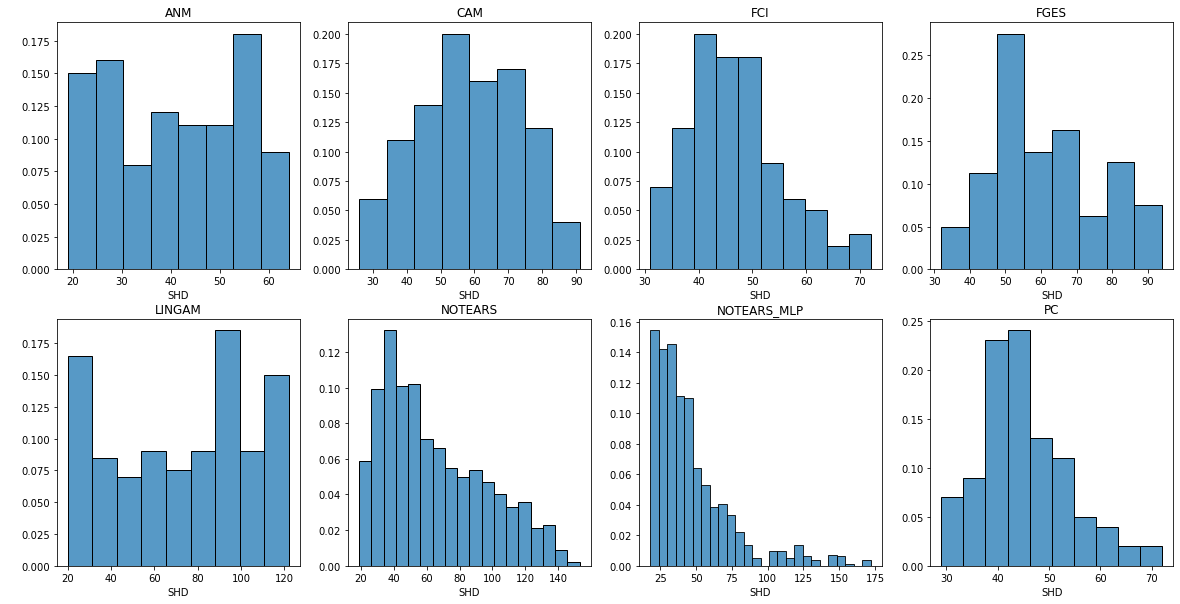

In [65]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for ax, alg in zip(axes, algs):
    ax.set_title(alg.upper())
    ax.set_xlabel('SHD')
    ax.set_ylabel(' ')
    sns.histplot(df.loc[df['id'] == alg, 'SHD_pattern'], ax=ax, stat='probability')

<AxesSubplot:xlabel='SHD_pattern', ylabel='id'>

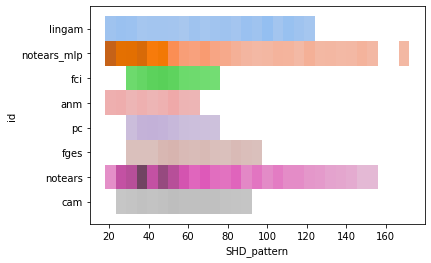

In [66]:
sns.histplot(df, x='SHD_pattern', y='id', hue='id', legend=False)